In [2]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn import metrics

In [3]:
# import csv as data frame from amazon s3 bucket that is connected to database
df = pd.read_csv('https://mydataclassdb-bucket.s3.amazonaws.com/covid_and_politics_db.csv')
df.head()

,county,state,county_state,lat,long,totalpop,total_votes20,votes20_donald_trump,votes20_joe_biden,percentage20_donald_trump,...,age_55to64,age_65to74,age_75to84,age_84plus,evangelicals,protestant,catholic,orthodox,muslim,other
0,Kay,OK,"Kay, OK",36.817997,-97.144214,45173,17249,12834,4040,0.744,...,5694,4632,2724,1183,0,0,0,0,0,0
1,Abbeville,SC,"Abbeville, SC",34.223334,-82.461707,24788,12433,8215,4101,0.661,...,3584,3150,1602,591,0,0,0,0,0,0
2,Acadia,LA,"Acadia, LA",30.295065,-92.414197,62607,28425,22596,5443,0.795,...,0,0,0,0,0,0,0,0,0,0
3,Accomack,VA,"Accomack, VA",37.767072,-75.632346,32840,16938,9172,7578,0.542,...,5270,4451,2301,886,0,0,0,0,0,0
4,Ada,ID,"Ada, ID",43.452658,-116.241552,435117,259389,130699,120539,0.504,...,56615,42027,18576,7189,0,0,0,0,0,0


In [4]:
# check columns
df.columns

Index(['county', 'state', 'county_state', 'lat', 'long', 'totalpop',
       'total_votes20', 'votes20_donald_trump', 'votes20_joe_biden',
       'percentage20_donald_trump', 'percentage20_joe_biden', 'cases',
       'deaths', 'men', 'women', 'hispanic', 'white', 'black', 'native',
       'asian', 'pacific', 'income', 'incomepercap', 'poverty', 'professional',
       'service', 'office', 'construction', 'production', 'drive', 'carpool',
       'transit', 'walk', 'othertransp', 'workathome', 'meancommute',
       'employed', 'privatework', 'publicwork', 'selfemployed', 'familywork',
       'unemployment', 'cases_per_capita_100k', 'deaths_per_capita_100k',
       'pop_per_sq_mile_2010', 'age_oto4', 'age_5to14', 'age_15to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_55to64', 'age_65to74',
       'age_75to84', 'age_84plus', 'evangelicals', 'protestant', 'catholic',
       'orthodox', 'muslim', 'other'],
      dtype='object')

# RFR for Economics

In [5]:
# create economic dataframe for pca
econ_df = df[['cases','income', 'incomepercap', 'poverty', 'employed', 'unemployment', 'professional']]
econ_df.head()

,cases,income,incomepercap,poverty,employed,unemployment,professional
0,920,44067,24057,17.6,19325,6.9,28.2
1,805,35254,19234,22.7,9505,9.4,27.2
2,3182,40492,21591,21.5,24982,8.9,27.6
3,1227,42260,24266,19.8,13837,5.4,31.1
4,17451,60151,31642,11.8,214984,4.3,43.0


In [7]:
# create scaled df
econ_scaled = RobustScaler().fit_transform(econ_df)
econ_scaled[:5]

array([[ 0.17101449, -0.26861502, -0.16135242,  0.3       ,  0.3513928 ,
         0.26470588, -0.30263158],
       [ 0.09694042, -0.88405873, -0.83658255,  0.9375    , -0.04750637,
         1.        , -0.43421053],
       [ 1.62801932, -0.51827022, -0.5065976 ,  0.7875    ,  0.58118634,
         0.85294118, -0.38157895],
       [ 0.36876006, -0.39480438, -0.13209198,  0.575     ,  0.12846422,
        -0.17647059,  0.07894737],
       [10.81900161,  0.85458894,  0.90056351, -0.425     ,  8.29927593,
        -0.5       ,  1.64473684]])

In [8]:
scaled_econ_df = pd.DataFrame(econ_scaled, columns= ['cases','Income', 'IncomePerCap', 'Poverty', 'Employed', 'Unemployment', 'Professional'])
scaled_econ_df.head()

,cases,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,0.171014,-0.268615,-0.161352,0.3000,0.351393,0.264706,-0.302632
1,0.096940,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
2,1.628019,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
3,0.368760,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
4,10.819002,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737


In [9]:
y = scaled_econ_df['cases']
scaled_cases = pd.DataFrame(y, columns = ['cases'])
scaled_cases.head()

,cases
0,0.171014
1,0.096940
2,1.628019
3,0.368760
4,10.819002


In [10]:
X_scaled = scaled_econ_df.drop(['cases'], axis=1)
X_scaled.head()

,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,-0.268615,-0.161352,0.3000,0.351393,0.264706,-0.302632
1,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
2,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
3,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
4,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737


In [11]:
# initialize pca model
pca = PCA(n_components=2)

In [12]:
# get two principal components for the iris data
X = pca.fit_transform(X_scaled)
X[:5]

array([[-1.20221174,  0.56503032],
       [-1.66237441,  1.81758077],
       [-1.00409553,  1.36181424],
       [-1.4181055 ,  0.4092722 ],
       [ 6.89369296, -1.41157477]])

In [14]:
# instantiate model
regressor = RandomForestRegressor(n_estimators=100,random_state=48)

In [15]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

In [16]:
# fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=48)

In [17]:
# make predictions
y_pred = regressor.predict(X_test)
y_pred[:5]

array([-0.24289211,  1.19142673, -0.26883092, -0.02634461, -0.16878583])

In [19]:
# Create df with pca and predictions
econ_pca_pred = pd.DataFrame(
    data=X, columns=["principal component 1", "principal component 2"]
)
econ_pca_pred.head()

,principal component 1,principal component 2
0,-1.202212,0.565030
1,-1.662374,1.817581
2,-1.004096,1.361814
3,-1.418106,0.409272
4,6.893693,-1.411575


In [20]:
# check explained variance
print(pca.explained_variance_)

[41.84944075  2.40138947]


In [22]:
# directions of maximum variance in the data
print(pca.components_)

[[ 0.04003528  0.03929823 -0.01145061  0.99765608  0.00163436  0.03743496]
 [-0.50381653 -0.4858889   0.45747131  0.05765967  0.40482044 -0.36550876]]


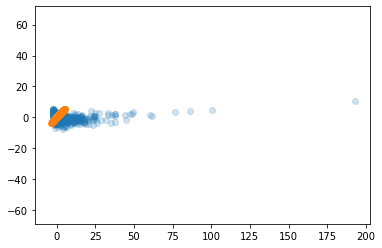

In [92]:
# Graph PCA and original data
X_new = pca.inverse_transform(X)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

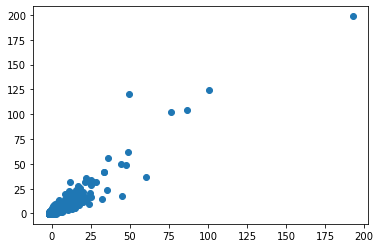

In [24]:
# plot training data
plt.scatter(X_train[:,0], y_train)

plt.show()

In [25]:
# check score
regressor.score(X_train, y_train)

0.9830087933551737

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.5793563425344777
Mean Squared Error: 1.9575713448129384
Root Mean Squared Error: 1.3991323542870913
R Squared: 0.9045786120568512


In [27]:
pred_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred})
pred_df.head()

,Real Values,Predicted Values
1050,-0.031884,-0.242892
697,1.368438,1.191427
1636,0.075040,-0.268831
2655,-0.234138,-0.026345
2752,-0.061514,-0.168786


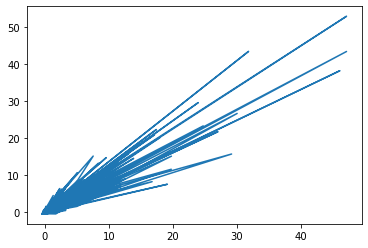

In [28]:
# plot line chart for predictions
plt.plot(pred_df['Predicted Values'], pred_df['Real Values'])
plt.show()

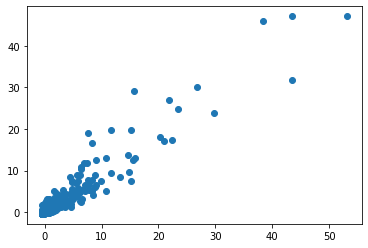

In [29]:
plt.scatter(pred_df['Real Values'], pred_df['Predicted Values'])
plt.show()

# RFR for Voting

In [30]:
# create voting df
voting_df = df[['cases','total_votes20','votes20_donald_trump','votes20_joe_biden']]
voting_df.head()

,cases,total_votes20,votes20_donald_trump,votes20_joe_biden
0,920,17249,12834,4040
1,805,12433,8215,4101
2,3182,28425,22596,5443
3,1227,16938,9172,7578
4,17451,259389,130699,120539


In [31]:
# scale voting data
voting_scaled = RobustScaler().fit_transform(voting_df)
voting_scaled[:5]

array([[ 0.17101449,  0.21058371,  0.29865829,  0.06631744],
       [ 0.09694042,  0.02301738,  0.01404871,  0.07280559],
       [ 1.62801932,  0.64584976,  0.90016483,  0.21554498],
       [ 0.36876006,  0.19847135,  0.07301631,  0.44263036],
       [10.81900161,  9.64108855,  7.56116272, 12.45752121]])

In [32]:
# create scaled df
scaled_voting_df = pd.DataFrame(voting_scaled, columns= ['cases','total_votes20','votes20_Donald_Trump','votes20_Joe_Biden'])
scaled_voting_df.head()

,cases,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden
0,0.171014,0.210584,0.298658,0.066317
1,0.096940,0.023017,0.014049,0.072806
2,1.628019,0.645850,0.900165,0.215545
3,0.368760,0.198471,0.073016,0.442630
4,10.819002,9.641089,7.561163,12.457521


In [33]:
# separate target
y2 = scaled_voting_df['cases']
scaled_cases2 = pd.DataFrame(y, columns = ['cases'])
scaled_cases2.head()

,cases
0,0.171014
1,0.096940
2,1.628019
3,0.368760
4,10.819002


In [34]:
# create features for model
X_scaled2 = scaled_voting_df.drop(['cases'], axis=1)
X_scaled2.head()

,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden
0,0.210584,0.298658,0.066317
1,0.023017,0.014049,0.072806
2,0.645850,0.900165,0.215545
3,0.198471,0.073016,0.442630
4,9.641089,7.561163,12.457521


In [35]:
# get two principal components for the iris data
X2 = pca.fit_transform(X_scaled2)
X2[:5]

array([[-2.44845335,  0.02414555],
       [-2.60478289, -0.27875697],
       [-1.96243507,  0.60491956],
       [-2.19494797, -0.33413577],
       [14.32089853,  3.76516877]])

In [59]:
# instantiate model
regressor2 = RandomForestRegressor(n_estimators=100,random_state=48)

In [60]:
# split data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=48)

In [61]:
# fit model
regressor2.fit(X_train2, y_train2)

RandomForestRegressor(random_state=48)

In [62]:
# make predictions
y_pred2 = regressor2.predict(X_test2)
y_pred2[:5]

array([ 0.01424155,  0.44151369, -0.12903704, -0.02758132,  0.02633816])

In [63]:
# plot components
print(pca.explained_variance_)

[168.27437185  72.55441636]


In [64]:
# Create df with pca and predictions
voting_pca_pred = pd.DataFrame(
    data=X2, columns=["principal component 1", "principal component 2"]
)
voting_pca_pred.head()

,principal component 1,principal component 2
0,-2.448453,0.024146
1,-2.604783,-0.278757
2,-1.962435,0.604920
3,-2.194948,-0.334136
4,14.320899,3.765169


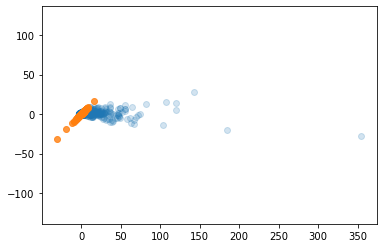

In [93]:
# Graph PCA and original data
X2_new = pca.inverse_transform(X2)
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.2)
plt.scatter(X2_new[:, 0], X2_new[:, 1], alpha=0.8)
plt.axis('equal');

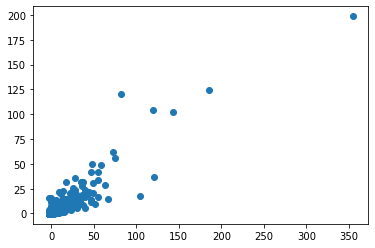

In [66]:
# plot training data
plt.scatter(X_train2[:,0], y_train2)
plt.show()

In [67]:
# check score
regressor2.score(X_train2, y_train2)

0.9672661066793056

In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test2, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
print('R Squared:', metrics.r2_score(y_test2, y_pred2))

Mean Absolute Error: 0.8875657583864818
Mean Squared Error: 9.741218093077629
Root Mean Squared Error: 3.12109245186323
R Squared: 0.5251664501723672


In [69]:
# create df with predictions and actual values
voting_pred_df = pd.DataFrame({'Real Values': y_test2, 'Predicted Values': y_pred2})
voting_pred_df.head()

,Real Values,Predicted Values
1050,-0.031884,0.014242
697,1.368438,0.441514
1636,0.075040,-0.129037
2655,-0.234138,-0.027581
2752,-0.061514,0.026338


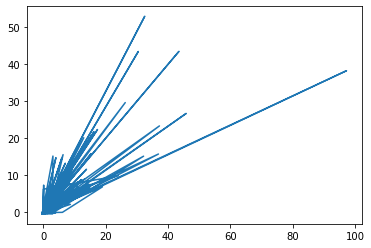

In [70]:
# plot line chart for predictions
plt.plot(voting_pred_df['Predicted Values'], voting_pred_df['Real Values'])
plt.show()

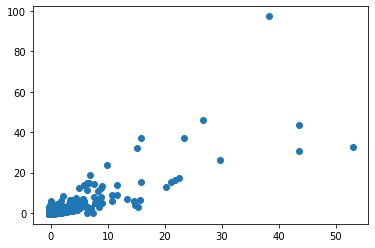

In [71]:
# plot predicted and real values
plt.scatter(voting_pred_df['Real Values'], voting_pred_df['Predicted Values'])
plt.show()

# RFR for Demographic Data

In [72]:
# create voting df
demo_df = df[['cases','men', 'women', 'hispanic', 'white', 'black', 'native','asian', 'pacific']]
demo_df.head()

,cases,men,women,hispanic,white,black,native,asian,pacific
0,920,22375,22798,7.6,75.4,2.0,7.4,0.5,0.0
1,805,12044,12744,1.3,68.9,27.6,0.1,0.3,0.0
2,3182,30433,32174,2.4,77.5,17.6,0.1,0.1,0.0
3,1227,16079,16761,8.8,60.3,28.3,0.3,0.7,0.0
4,17451,217999,217118,7.9,85.2,1.2,0.4,2.6,0.1


In [73]:
# scale demographic data
demo_scaled = RobustScaler().fit_transform(demo_df)
demo_scaled[:5]

array([[ 1.71014493e-01,  3.45629910e-01,  3.51384643e-01,
         5.00000000e-01, -3.33333333e-01, -1.08695652e-02,
         1.42000000e+01, -1.11111111e-01,  0.00000000e+00],
       [ 9.69404187e-02, -2.79136196e-02, -4.99800611e-03,
        -3.51351351e-01, -5.71428571e-01,  2.77173913e+00,
        -4.00000000e-01, -3.33333333e-01,  0.00000000e+00],
       [ 1.62801932e+00,  6.36987354e-01,  6.83734326e-01,
        -2.02702703e-01, -2.56410256e-01,  1.68478261e+00,
        -4.00000000e-01, -5.55555556e-01,  0.00000000e+00],
       [ 3.68760064e-01,  1.17982048e-01,  1.37391998e-01,
         6.62162162e-01, -8.86446886e-01,  2.84782609e+00,
         0.00000000e+00,  1.11111111e-01,  0.00000000e+00],
       [ 1.08190016e+01,  7.41891220e+00,  7.23941690e+00,
         5.40540541e-01,  2.56410256e-02, -9.78260870e-02,
         2.00000000e-01,  2.22222222e+00,  1.00000000e+00]])

In [74]:
# create scaled df
scaled_demo_df = pd.DataFrame(demo_scaled, columns= ['cases','Men', 'Women', 'Hispanic', 'White', 'Black', 'Native','Asian', 'Pacific'])
scaled_demo_df.head()

,cases,Men,Women,Hispanic,White,Black,Native,Asian,Pacific
0,0.171014,0.345630,0.351385,0.500000,-0.333333,-0.010870,14.2,-0.111111,0.0
1,0.096940,-0.027914,-0.004998,-0.351351,-0.571429,2.771739,-0.4,-0.333333,0.0
2,1.628019,0.636987,0.683734,-0.202703,-0.256410,1.684783,-0.4,-0.555556,0.0
3,0.368760,0.117982,0.137392,0.662162,-0.886447,2.847826,0.0,0.111111,0.0
4,10.819002,7.418912,7.239417,0.540541,0.025641,-0.097826,0.2,2.222222,1.0


In [75]:
# separate target
y3 = scaled_demo_df['cases']
scaled_cases3 = pd.DataFrame(y, columns = ['cases'])
scaled_cases3.head()

,cases
0,0.171014
1,0.096940
2,1.628019
3,0.368760
4,10.819002


In [76]:
# create features for model
X_scaled3 = scaled_demo_df.drop(['cases'], axis=1)
X_scaled3.head()

,Men,Women,Hispanic,White,Black,Native,Asian,Pacific
0,0.345630,0.351385,0.500000,-0.333333,-0.010870,14.2,-0.111111,0.0
1,-0.027914,-0.004998,-0.351351,-0.571429,2.771739,-0.4,-0.333333,0.0
2,0.636987,0.683734,-0.202703,-0.256410,1.684783,-0.4,-0.555556,0.0
3,0.117982,0.137392,0.662162,-0.886447,2.847826,0.0,0.111111,0.0
4,7.418912,7.239417,0.540541,0.025641,-0.097826,0.2,2.222222,1.0


In [77]:
# get two principal components
X3 = pca.fit_transform(X_scaled3)
X3[:5]

array([[11.75044231, -1.00772818],
       [-2.8212884 , -2.31709428],
       [-2.85869588, -1.43335498],
       [-2.44160715, -1.96235347],
       [-2.76179951,  8.39265439]])

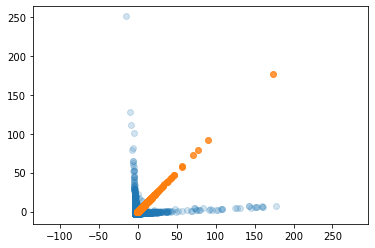

In [78]:
# Graph PCA and original data
X3_new = pca.inverse_transform(X3)
plt.scatter(X3[:, 0], X3[:, 1], alpha=0.2)
plt.scatter(X3_new[:, 0], X3_new[:, 1], alpha=0.8)
plt.axis('equal');

In [79]:
# instantiate model
regressor3 = RandomForestRegressor(n_estimators=100,random_state=48)

In [80]:
# split data into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=48)

In [81]:
# fit model
regressor3.fit(X_train3, y_train3)

RandomForestRegressor(random_state=48)

In [82]:
# make predictions
y_pred3 = regressor3.predict(X_test3)
y_pred3[:5]

array([-0.26234461,  1.45918196,  0.02255717, -0.17190982, -0.20798712])

In [83]:
# explore pca
print(pca.explained_variance_)

[168.27437185  72.55441636]


In [84]:
# Create df with pca and predictions
demo_pca_pred = pd.DataFrame(
    data=X3, columns=["principal component 1", "principal component 2"]
)
demo_pca_pred.head()

,principal component 1,principal component 2
0,11.750442,-1.007728
1,-2.821288,-2.317094
2,-2.858696,-1.433355
3,-2.441607,-1.962353
4,-2.761800,8.392654


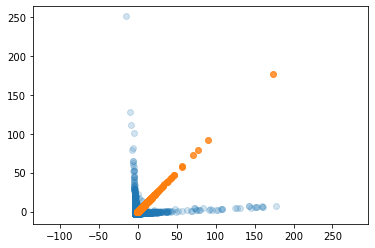

In [94]:
# Graph PCA and original data
X3_new = pca.inverse_transform(X3)
plt.scatter(X3[:, 0], X3[:, 1], alpha=0.2)
plt.scatter(X3_new[:, 0], X3_new[:, 1], alpha=0.8)
plt.axis('equal');

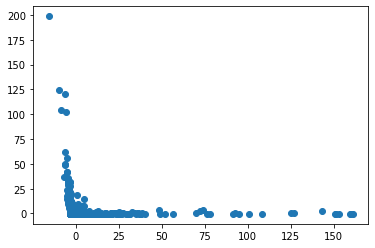

In [95]:
# plot training data
plt.scatter(X_train3[:,0], y_train3)
plt.show()

In [96]:
# check score
regressor3.score(X_train3, y_train3)

0.9767636593025791

In [97]:
# print model assessment metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test3, y_pred3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test3, y_pred3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test3, y_pred3)))
print('R Squared:', metrics.r2_score(y_test3, y_pred3))

Mean Absolute Error: 0.7076943208185931
Mean Squared Error: 4.055470761672166
Root Mean Squared Error: 2.0138199427138876
R Squared: 0.802316962869828


In [98]:
# create df with predictions and actual values
demo_pred_df = pd.DataFrame({'Real Values': y_test3, 'Predicted Values': y_pred3})
demo_pred_df.head()

,Real Values,Predicted Values
1050,-0.031884,-0.262345
697,1.368438,1.459182
1636,0.075040,0.022557
2655,-0.234138,-0.171910
2752,-0.061514,-0.207987


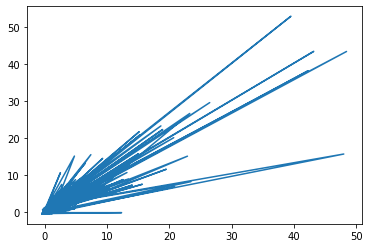

In [99]:
# plot line chart for predictions
plt.plot(demo_pred_df['Predicted Values'], demo_pred_df['Real Values'])
plt.show()

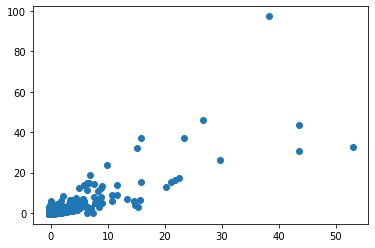

In [100]:
# plot scatter chart for predicted and real values
plt.scatter(voting_pred_df['Real Values'], voting_pred_df['Predicted Values'])
plt.show()